<a href="https://colab.research.google.com/github/reedmarkham/meter-made/blob/main/meter_made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import datetime

from google.colab import drive
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import geopandas as gpd
import folium
import branca.colormap as cm
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Load the DC parking data previously downloaded to Google Drive

In [4]:
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/dc-parking-data'

Mounted at /content/drive
Accessible_Parking_Zones.geojson		    Parking_Zones.geojson
Address_Points.geojson				    Residential_and_Visitor_Parking_Zones.geojson
Parking_Blockface.geojson			    Roadway_Blockface.geojson
Parking_Violations_Issued_in_December_2024.geojson  Street_Right_Of_Way.geojson
Parking_Violations_Issued_in_June_2024.geojson	    Valet_Parking.geojson


# Check out the DC parking zones (street sweeping routes)

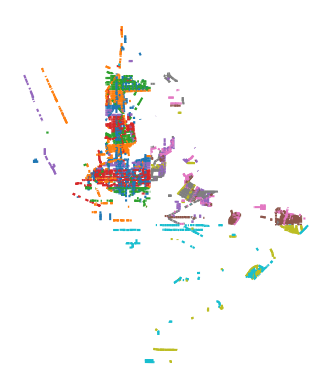

In [5]:
zones = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Zones.geojson')
ax = zones[zones.PARKINGGROUP == 'Sweeping'].plot(column='ROUTEID')
ax.set_axis_off()

# Ingest addresses and routes

In [6]:
addresses = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Address_Points.geojson')
a_cols = ['ADDRESS', 'ZIPCODE', 'BLOCKKEY', 'ROUTEID', 'LATITUDE', 'LONGITUDE']
addresses = addresses[a_cols]

# & (gdf.ROUTEID == '11072862')
routes = zones[(zones.PARKINGGROUP == 'Sweeping') & (zones.PARKINGDAYGROUP == 'Monday') & (zones.PARKINGHOURGROUP == 'AM')].set_crs('EPSG:4326')
routes = routes.sort_values(by='MEAS_FROM')
r_cols = ['ROUTEID', 'ZONEID', 'SIGNS', 'SIGNTEXT', 'SIGNCODE', 'MEAS_FROM', 'MEAS_TO', 'STARTTIME', 'ENDTIME', 'BLOCKFACEKEY', 'geometry']
routes = routes[r_cols]

routes_df = routes.merge(addresses, on='ROUTEID', how='inner')
routes_gdf = gpd.GeoDataFrame(
    routes_df,
    geometry=gpd.points_from_xy(routes_df.LONGITUDE, routes_df.LATITUDE),
    crs='EPSG:4326'
)

display(routes_gdf.sort_values(by='ADDRESS'))

,ROUTEID,ZONEID,SIGNS,SIGNTEXT,SIGNCODE,MEAS_FROM,MEAS_TO,STARTTIME,ENDTIME,BLOCKFACEKEY,geometry,ADDRESS,ZIPCODE,BLOCKKEY,LATITUDE,LONGITUDE
162405,11068382,b17df5ba43d9090d7fb1c6888ad5710c-left-1,"69707B76,9406DFDD",,R-NS-022,2436.798096,2517.250244,23.0,31.0,b17df5ba43d9090d7fb1c6888ad5710c,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
174799,11068382,5a1ef58455d9e8f59882cd6be3db8cec-left-0,"6C18511A,B49A4FF8,06C552E7,D85114EC",None,R-NS-022,2589.184814,2700.219482,23.0,31.0,5a1ef58455d9e8f59882cd6be3db8cec,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
223608,11068382,b29d88b46d5cd801e5007dc09163857f-right-2,"C4A733FA,E70DB290,2A48C50B,1FB37F0B,430D2FE0",,R-NS-022,3543.365479,3701.366455,23.0,31.0,b29d88b46d5cd801e5007dc09163857f,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
157253,11068382,84cf5ad23b44a52bbab608c63339bc8e-left-1,"BDA72933,74D960FB",,R-NS-022,2336.048096,2425.520508,23.0,31.0,84cf5ad23b44a52bbab608c63339bc8e,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
171602,11068382,46a76de4c58cce77f347c18c4d4d3525-left-0,DB9F1379,,R-NS-022,2529.746826,2576.688232,23.0,31.0,46a76de4c58cce77f347c18c4d4d3525,POINT (-77.00961 38.90979),1 1/2 P STREET NW,20001.0,eee69cf95ada34e062d5c1e1f7afd6c2,38.909787,-77.009606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312150,11000902,0fbbc26c002e9b0bc4e6092049110bdb-left-1,"FB648B3A,D193CC03",,R-NS-022,7060.233398,7100.389648,23.0,31.0,0fbbc26c002e9b0bc4e6092049110bdb,POINT (-77.02397 38.88975),None,20004.0,ea6918a50e1295d78553a3d6f022e8b5,38.889749,-77.023974
312340,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234
312968,11001302,6725c8ddf0a46131a1ff626c42f7eb7b-right-0,B2024598,,R-NS-022,7142.083008,7158.758301,23.0,31.0,6725c8ddf0a46131a1ff626c42f7eb7b,POINT (-77.02923 38.96446),None,20011.0,c2d1955d497def9cef4c8fdb1230459d,38.964463,-77.029228
313250,11001302,19988afe7a283be8f02099b1b4f7a904-right-1,"C21C8818,D35B104F",,R-NS-022,7170.645020,7207.974609,23.0,31.0,19988afe7a283be8f02099b1b4f7a904,POINT (-77.02823 38.94294),None,20011.0,3c94c4567539be3cc91386edeb5ae696,38.942943,-77.028234


# Ingest tickets

In [30]:
t = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_June_2024.geojson')

tickets = gpd.GeoDataFrame(
    t,
    geometry=gpd.points_from_xy(t.LONGITUDE, t.LATITUDE),
    crs="EPSG:4326"
)

# Fill NaN values in VIOLATION_PROC_DESC with an empty string before using .str.contains()
tickets['VIOLATION_PROC_DESC'] = tickets['VIOLATION_PROC_DESC'].fillna('')

display(tickets[tickets.VIOLATION_PROC_DESC.str.contains('EXPIRED METER')])

,OBJECTID,TICKET_NUMBER,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,LOCATION,PLATE_STATE,...,YCOORD,LATITUDE,LONGITUDE,MAR_ID,GIS_LAST_MOD_DTTM,VIOLATION_PROC_DESC,VEHICLE_TYPE,MULTI_OWNER_NUMBER,DISPOSITION_DESC,geometry
164,83177787,280259103,2024-06-11 04:00:00+00:00,1035,57,METRO POLICE,MTP,P039,1101 HOWARD RD SE,,...,132706.81,38.862,-76.995,294866.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.862)
177,83177800,280260573,2024-06-10 04:00:00+00:00,1052,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,950002387,DISM NOI SUBM LATE,POINT (-76.994 38.934)
178,83177801,280260584,2024-06-16 04:00:00+00:00,1059,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM MAKE MISMATCH,POINT (-76.994 38.934)
179,83177802,280260595,2024-06-10 04:00:00+00:00,1100,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.994 38.934)
180,83177803,280260606,2024-06-10 04:00:00+00:00,1102,57,METRO POLICE,MTP,P039,890 MONROE ST NE,,...,140633.98,38.934,-76.994,316412.0,2024-07-16 14:04:28+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.994 38.934)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97289,83379818,280260304,2024-06-25 04:00:00+00:00,1059,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)
97290,83379819,280260326,2024-06-25 04:00:00+00:00,1101,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)
97291,83379820,280260330,2024-06-25 04:00:00+00:00,1103,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,REAR 850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)
97292,83379821,280260341,2024-06-25 04:00:00+00:00,1105,1,METROPOLITAN POLICE DPT-DISTRICT 1,MPD-1D,P039,REAR 850 HOWARD RD SE,,...,132977.54,38.865,-76.995,316456.0,2024-09-16 14:05:10+00:00,PARK AT EXPIRED METER,None,0,DISM NOI SUBM LATE,POINT (-76.995 38.865)


# Join street cleaning parking tickets with sweeping routes

In [32]:
routes_gdf.geometry = routes_gdf.geometry.set_precision(grid_size=0.0001).force_2d()
cleaning_tix = tickets[tickets.VIOLATION_CODE == 'P173']
cleaning_tix.geometry = cleaning_tix.geometry.set_precision(grid_size=0.0001).force_2d()
tickets_and_routes = gpd.sjoin(routes_gdf, cleaning_tix, how='inner', predicate='intersects')
tickets_and_routes = tickets_and_routes[['TICKET_NUMBER', 'ROUTEID', 'ISSUE_DATE', 'ISSUE_TIME', 'geometry']]
tickets_and_routes = tickets_and_routes.sort_values(by='TICKET_NUMBER').drop_duplicates()
tickets_and_routes.geometry = tickets_and_routes.geometry.set_precision(grid_size=0.00001)
display(tickets_and_routes)

/usr/local/lib/python3.11/dist-packages/shapely/_geometry.py:814: RuntimeWarning: invalid value encountered in set_precision
  return lib.set_precision(geometry, grid_size, np.intc(mode), **kwargs)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,TICKET_NUMBER,ROUTEID,ISSUE_DATE,ISSUE_TIME,geometry
56235,8262204646,11064872,2024-06-03 04:00:00+00:00,1029,POINT (-77.021 38.96)
255286,8262205070,11001302,2024-06-04 04:00:00+00:00,1047,POINT (-77.03 38.937)
202608,8262205081,11001302,2024-06-04 04:00:00+00:00,1048,POINT (-77.03 38.937)
269330,8262205092,11001302,2024-06-04 04:00:00+00:00,1050,POINT (-77.03 38.937)
303474,8262205103,11001302,2024-06-04 04:00:00+00:00,1054,POINT (-77.03 38.936)
...,...,...,...,...,...
15817,8268474583,11025932,2024-06-26 04:00:00+00:00,1014,POINT (-77.031 38.912)
15749,8268519545,11025932,2024-06-26 04:00:00+00:00,1122,POINT (-77.031 38.912)
15817,8268519556,11025932,2024-06-26 04:00:00+00:00,1124,POINT (-77.031 38.912)
15817,8268519560,11025932,2024-06-26 04:00:00+00:00,1125,POINT (-77.031 38.912)


In [33]:
tickets_and_routes['timestamp'] = tickets_and_routes.apply(
    lambda row: str(row['ISSUE_DATE'].date()) + ' ' + row['ISSUE_TIME'],
    axis=1
    )

tickets_and_routes['timestamp'] = pd.to_datetime(
    tickets_and_routes['timestamp'],
    format='%Y-%m-%d %H%M',
    errors='coerce'
    )

tickets_and_routes = tickets_and_routes[['geometry', 'ROUTEID', 'timestamp']]

display(tickets_and_routes)

,geometry,ROUTEID,timestamp
56235,POINT (-77.021 38.96),11064872,2024-06-03 10:29:00
255286,POINT (-77.03 38.937),11001302,2024-06-04 10:47:00
202608,POINT (-77.03 38.937),11001302,2024-06-04 10:48:00
269330,POINT (-77.03 38.937),11001302,2024-06-04 10:50:00
303474,POINT (-77.03 38.936),11001302,2024-06-04 10:54:00
...,...,...,...
15817,POINT (-77.031 38.912),11025932,2024-06-26 10:14:00
15749,POINT (-77.031 38.912),11025932,2024-06-26 11:22:00
15817,POINT (-77.031 38.912),11025932,2024-06-26 11:24:00
15817,POINT (-77.031 38.912),11025932,2024-06-26 11:25:00


# Visualize frequency and order (by ticket timestamp) of parking tickets along routes

In [34]:
DC_COORDS = [38.90720, -77.03690]

map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

#TO-DO: compute elapsed_minutes within ROUTEID as well as colormap but then plot for each ROUTEID layer the respective colormap and elapsed_minutes in popup ("since street cleaning route started")

tickets_and_routes['elapsed_minutes'] = (tickets_and_routes['timestamp'] - tickets_and_routes['timestamp'].min()).dt.total_seconds() / 60

colormap = cm.linear.Blues_03.scale(
    tickets_and_routes.elapsed_minutes.min(),
    tickets_and_routes.elapsed_minutes.max()
    )

geometry_counts = tickets_and_routes.groupby(['geometry', 'ROUTEID'])['timestamp'].count().reset_index()
earliest_timestamps = tickets_and_routes.groupby(['geometry', 'ROUTEID'])['timestamp'].min().rename('earliest_timestamp').reset_index()

route_layers = {}
for route_id in tickets_and_routes['ROUTEID'].unique():
  route_data = tickets_and_routes[tickets_and_routes['ROUTEID'] == route_id]
  route_fg = folium.FeatureGroup(name=f"Route {route_id}")

  for idx, row in route_data.sort_values(by='elapsed_minutes').iterrows():
      lon = row.geometry.x
      lat = row.geometry.y
      count_for_geometry = int(geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].iloc[0] if geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].size > 0 else 0)
      earliest_timestamp = earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].iloc[0]

      popup_html = f"""
      <h1> Street sweeping summary:</h1>
      <p># of tickets: {count_for_geometry}</p>
      <p>Started at: {earliest_timestamp}</p>
      """

      folium.CircleMarker(
          location=[lat, lon],
          radius=count_for_geometry,
          color='none',
          fill=True,
          fill_color=colormap(row.elapsed_minutes),
          fill_opacity=0.7,
          popup=popup_html
      ).add_to(route_fg)

  route_layers[route_id] = route_fg
  route_fg.add_to(map)


colormap.add_to(map)
folium.LayerControl().add_to(map)

map

# Compute clusters of expired parking meter ticket locations (x, y coords)

In [37]:
tix = tickets[tickets.VIOLATION_CODE == 'P039']

array_data = []
for index, row in tix.iterrows():
  if row.geometry and row.geometry.is_valid and not row.geometry.is_empty:
    x_coord = row.geometry.x
    y_coord = row.geometry.y
    date = row['ISSUE_DATE'].date()

    try:
        time_of_day = datetime.time(int(row['ISSUE_TIME'].zfill(4)[:2]), int(row['ISSUE_TIME'].zfill(4)[2:]))
    except (ValueError, TypeError):
        print(f"Invalid time format: {row['ISSUE_TIME']}, skipping row")
        continue

    #day_of_week =  row['ISSUE_DATE'].date().isoweekday()
    array_data.append([x_coord, y_coord, date, time_of_day])

X_full = np.array(array_data)
display(pd.DataFrame(X_full, columns=['x', 'y', 'd', 't']))

,x,y,d,t
0,-76.995,38.862,2024-06-11,10:35:00
1,-76.994,38.934,2024-06-10,10:52:00
2,-76.994,38.934,2024-06-16,10:59:00
3,-76.994,38.934,2024-06-10,11:00:00
4,-76.994,38.934,2024-06-10,11:02:00
...,...,...,...,...
3118,-76.995,38.865,2024-06-25,10:59:00
3119,-76.995,38.865,2024-06-25,11:01:00
3120,-76.995,38.865,2024-06-25,11:03:00
3121,-76.995,38.865,2024-06-25,11:05:00


In [38]:
# prompt: For each date in d and hour of day in t from X_full compute respective DBSCAN cluster labels using x and y as coordinates

from sklearn.cluster import DBSCAN

def compute_dbscan_labels(X_full, d, t, x_col='x', y_col='y', eps=0.001, min_samples=5):
  """
  Computes DBSCAN cluster labels for a specific date and hour.

  Args:
    X_full: The numpy array containing x, y, date, and time information.
    d: The date to filter for.
    t: The hour of day to filter for.
    x_col: The column name for x coordinates.
    y_col: The column name for y coordinates.
    eps: The epsilon parameter for DBSCAN.
    min_samples: The minimum samples parameter for DBSCAN.

  Returns:
    A list of DBSCAN cluster labels for the specified date and hour.
  """

  X_filtered = X_full[(X_full[:, 2] == d) & (X_full[:, 3].astype(str) == str(t))]

  if X_filtered.size > 0:
    X_coords = X_filtered[:, [0, 1]]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_coords)
    return labels.tolist()
  else:
    return []


# Example usage:
# Assuming X_full, d, and t are defined as in your provided code
# d = datetime.date(2024, 6, 1)
# t = datetime.time(10, 0)
# labels = compute_dbscan_labels(X_full, d, t)
# print(labels)

In [ ]:
# Iterate through dates and hours to compute labels for each combination
date_list = X_full[:, 2].tolist()
time_list = X_full[:, 3].tolist()

all_labels = []  # Initialize an empty list to store the data

for d in set(date_list):
  for t in set(time_list):
    labels = compute_dbscan_labels(X_full, d, t)
    for label in labels:
      all_labels.append({'date': d, 'time': t, 'label': label})

# Create the DataFrame after the loop
all_cluster_labels = pd.DataFrame(all_labels)
display(all_cluster_labels)